In [1]:
import time
import glob
import itertools
import collections

import numpy as np

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 13, 10

In [2]:
#OpenCV helper
COLORSPACE_CONVERSION = {'HSV': cv2.COLOR_RGB2HSV,
                         'LUV': cv2.COLOR_RGB2LUV,
                         'HLS': cv2.COLOR_RGB2HLS,
                         'YUV': cv2.COLOR_RGB2YUV,
                         'YCrCb': cv2.COLOR_RGB2YCrCb}

## Dataset exploration

In [4]:
# Read in our vehicles and non-vehicles
cars = glob.glob("./datasets/vehicles/*/*.png")
non_cars = glob.glob("./datasets/non-vehicles/*/*.png")

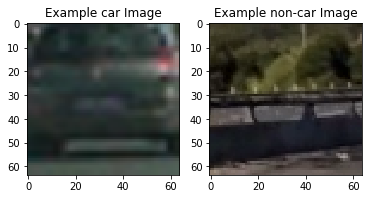

In [5]:
np.random.seed(10)

# example : choose random car / not-car indices and plot  
car_ind = np.random.randint(0, len(cars))
non_car_ind = np.random.randint(0, len(non_cars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
non_car_image = mpimg.imread(non_cars[non_car_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example car Image')
plt.subplot(122)
plt.imshow(non_car_image)
plt.title('Example non-car Image');

%xdel car_image
%xdel non_car_image

In [6]:
len(cars), len(non_cars)

(8792, 8968)

I'll use HOG features, spatial features and color histograms:

In [ ]:
#Let's define a few helper functions:

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis is True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = np.copy(image) if color_space == 'RGB' \
                        else cv2.cvtColor(image, COLORSPACE_CONVERSION[color_space])
        file_features = []
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat:
        # Call get_hog_features() with vis=False, feature_vec=True
            assert hog_channel in (0, 1, 2, "ALL")
            if hog_channel == 'ALL':
                hog_features = np.ravel([get_hog_features(feature_image[:,:, channel], 
                                        orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                                        for channel in range(feature_image.shape[2])])     
            else:
                hog_features = get_hog_features(feature_image[:,:, hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        #We now concatenate spatial_features | hist_features | hog_features
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

## SVC training

In [8]:
# Read in our vehicles and non-vehicles
cars = glob.glob("./datasets/vehicles/*/*.png")
non_cars = glob.glob("./datasets/non-vehicles/*/*.png")

SAMPLE_SIZE = 100000

cars = cars[0:SAMPLE_SIZE]
non_cars = non_cars[0:SAMPLE_SIZE]

print("cars | non_cars :", len(cars), len(non_cars))

cars | non_cars : 8792 8968


First we compute the features of the cars and non cars.

In [9]:
### TODO: Tweak these parameters and see how the results change.
color_space = "LUV" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

#################################
#Do not change: these values are set to True in the 'find_cars' function
spatial_feat = True  # Spatial features on or off
hist_feat = True     # Histogram features on or off
hog_feat = True      # HOG features on or off
#################################

t0 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("====== done ======")
print('Time to extract features: {:.2f} sec'.format(time.time() - t0))

/Users/sebastienvincent/.virtualenvs/nd013/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time to extract features: 94.81 sec


Then we train the classifier with these features (we keep 20% of the dataset for validation)

In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
RAND_STATE = 42 #np.random.randint(0, 100)
TEST_SIZE = 0.20
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
print("Training on {} elts.\n".format(len(X_train)))

print('using:', orient,'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t0 = time.time()
svc.fit(X_train, y_train)
print('Time to train SVC: {:.2f} sec'.format(time.time() - t0))

# Check the score of the SVC
print('Test accuracy of SVC: {:.4f}'.format(svc.score(X_test, y_test)))

Training on 14208 elts.

using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284
Time to train SVC: 28.65 sec
Test accuracy of SVC: 0.9924


## Sliding window search

In [147]:
#lesson 35 : hog_subsample.py
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, hog_channel, ystart, ystop, scale, svc, scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, confidence_threshold=-1e6):
    
    assert hog_channel in (0,"ALL")

    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, COLORSPACE_CONVERSION[color_space])
    
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(ctrans_tosearch.shape[1]/scale), np.int(ctrans_tosearch.shape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []
    for xb, yb in itertools.product(range(nxsteps), range(nysteps)):
        xpos = xb * cells_per_step
        ypos = yb * cells_per_step

        # Extract HOG for this patch
        hog_feat1 = hog1[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel()             
        if hog_channel == "ALL":
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        elif hog_channel == 0:
            hog_features = hog_feat1
        else:
            raise RuntimeError 

        # Extract the image patch
        xleft = xpos * pix_per_cell
        ytop = ypos * pix_per_cell
        subimg = cv2.resize(ctrans_tosearch[ytop : ytop+window, xleft : xleft+window], (64,64))

        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)
        # Scale features and make a prediction
        test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        

        test_prediction = svc.predict(test_features).squeeze()
        #print('test_prediction', test_prediction[0])
        conf = svc.decision_function(test_features).squeeze()
        #print('debug2: decision_function {} | '.format(conf))
        
        #We draw boxes around positive predictions
        #see https://discussions.udacity.com/t/detection-fails-when-white-car-is-far-00-25-to-00-31/380480/6
        if test_prediction == 1 and conf > confidence_threshold:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            box_list.append( ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) )
                   
    return box_list


def draw_boxes(img, box_list):
    
    draw_img = np.copy(img)
    for box in box_list:
        cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)
    return draw_img

### test on an image

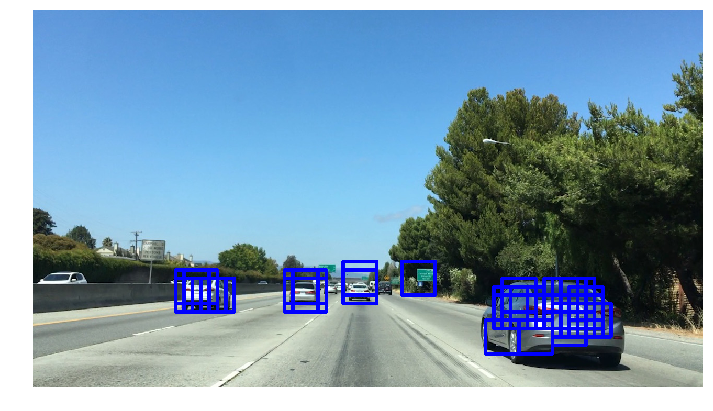

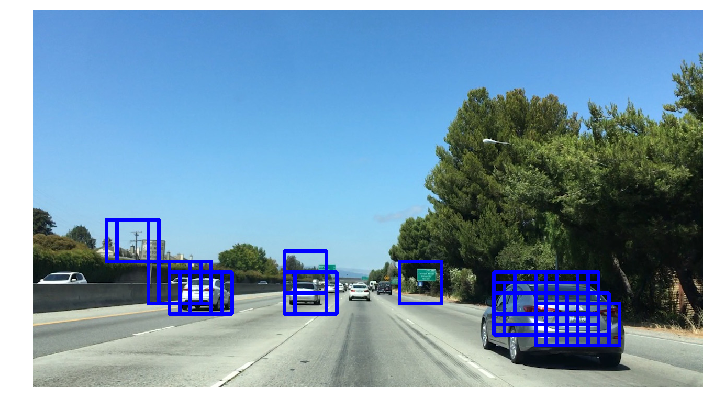

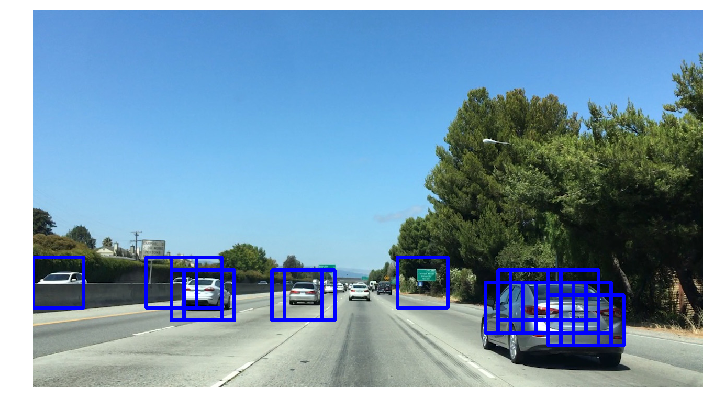

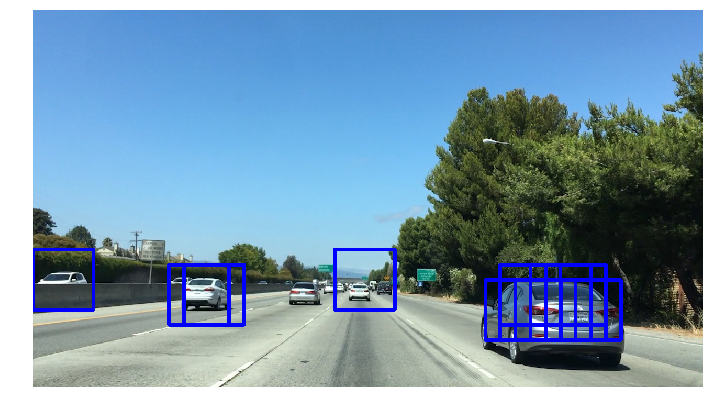

In [148]:
img = mpimg.imread('./test_images/bbox-example-image.jpg')
#img = mpimg.imread('./test_images/test1.jpg')


ystart = 400
ystop = 656
#scale = 1.5

scales = [1, 1.25, 1.5, 1.8]

for scale in scales:
    box_list = find_cars(img, color_space, hog_channel, ystart, ystop, scale, svc, X_scaler, orient, \
                    pix_per_cell, cell_per_block, spatial_size, hist_bins, confidence_threshold=.2)

    out_img = draw_boxes(img, box_list)

    #print('box_list:', box_list)

    plt.figure(figsize=(12,8))
    plt.imshow(out_img)
    plt.axis('off');

## Heat maps

As shown in lesson 37, we'll use heat maps for reducing the number of false positives.

In [149]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Here is the result on a test image.

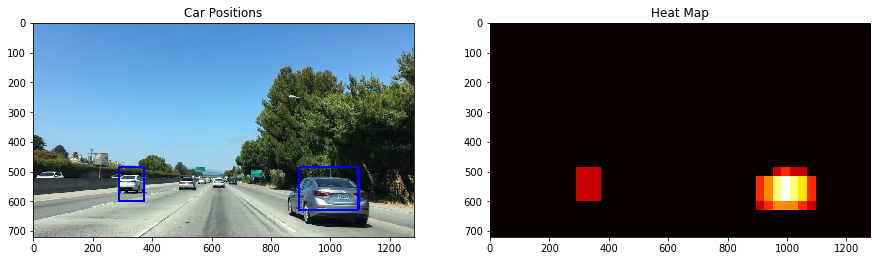

In [150]:
#image = mpimg.imread('./test_images/test3.jpg') #'./test_images/test4.jpg'
image = img

heat = np.zeros_like(image[:,:,0], dtype='float64')

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.figure(figsize=(15,10))

plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map');

In [151]:
heatmap.max()

7.0

# Final car tracker (for video)

In [154]:
class CarTracker(object):
    
    def __init__(self, cache=8, heat_threshold=3, confidence_threshold=.2):
        
        self.cache = cache #nb of images in cache
        self.scales = (1, 1.25, 1.5, 1.8)
        self.recent_boxes = collections.deque(maxlen=self.cache*len(self.scales))
        self.heat_threshold = heat_threshold
        print("Init with a deque of len", self.recent_boxes.maxlen)
        self.confidence_threshold = confidence_threshold
    
    def process(self, image):
        ystart, ystop = 400, 656

        for scale in self.scales:
            current_box_list = find_cars(image, color_space, hog_channel,  \
                                 ystart, ystop, scale, svc, X_scaler, \
                                 orient, pix_per_cell, cell_per_block, \
                                 spatial_size, hist_bins, confidence_threshold=self.confidence_threshold)
            self.recent_boxes.append(current_box_list)
        
        heat = np.zeros_like(image[:,:,0], dtype='float64')
        # Add heat to each box in box list
        #for box_list in self.recent_boxes:
        #    heat = add_heat(heat, box_list)
        it = itertools.chain.from_iterable(self.recent_boxes)
        heat = add_heat(heat, it)
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.heat_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        
        return draw_img

## Test on video

In [155]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [166]:
%%time
%%capture

ct = CarTracker(cache=16, heat_threshold=9, confidence_threshold=-1.5)

#Create video file pipeline
input_file = "project_video.mp4" #"project_video.mp4" #"challenge_video.mp4" # harder_challenge_video.mp4
output_file = "output_project_video6.mp4"

input_video = VideoFileClip(input_file)#.subclip(23,33) #.subclip(23,38)

t0 = time.time()
output_video = input_video.fl_image(ct.process)
output_video.write_videofile(output_file, audio=False)

CPU times: user 49min 32s, sys: 1min 4s, total: 50min 36s
Wall time: 50min 49s


# Tests

http://cslocumwx.github.io/blog/2015/02/23/python-multiprocessing/